In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop,SGD
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate3_RMSProp"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [8]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='softmax')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [9]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [10]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [11]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [12]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [13]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [14]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [15]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [16]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

rmsprop_opt=RMSprop(lr=0.0001, rho=0.8, epsilon=None, decay=0.0)
# sgd_opt=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
# adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.999, amsgrad=True)
model.compile(optimizer=rmsprop_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59170 samples, validate on 18384 samples
Epoch 1/1000
 - 7s - loss: 0.5351 - acc: 0.7459 - val_loss: 0.4982 - val_acc: 0.7780
Epoch 2/1000
 - 7s - loss: 0.4940 - acc: 0.7797 - val_loss: 0.4872 - val_acc: 0.7811
Epoch 3/1000
 - 6s - loss: 0.4880 - acc: 0.7813 - val_loss: 0.4839 - val_acc: 0.7827
Epoch 4/1000
 - 6s - loss: 0.4833 - acc: 0.7852 - val_loss: 0.4861 - val_acc: 0.7830
Epoch 5/1000
 - 6s - loss: 0.4798 - acc: 0.7854 - val_loss: 0.4769 - val_acc: 0.7883
Epoch 6/1000
 - 7s - loss: 0.4762 - acc: 0.7895 - val_loss: 0.4899 - val_acc: 0.7821
Epoch 7/1000
 - 6s - loss: 0.4727 - acc: 0.7905 - val_loss: 0.4722 - val_acc: 0.7920
Epoch 8/1000
 - 6s - loss: 0.4693 - acc: 0.7909 - val_loss: 0.4698 - val_acc: 0.7942
Epoch 9/1000
 - 6s - loss: 0.4673 - acc: 0.7928 - val_loss: 0.4694 - val_acc: 0.7950
Epoch 10/1000
 - 6s - loss: 0.4643 - acc: 0.7933 - val_loss: 0.4670 - val_acc: 0.7983
Epoch 11/1000
 - 7s - loss: 0.4620 - acc: 0.7939 - val_loss: 0.4693 - val_acc: 0.7947
Epoch 12/1000

Epoch 96/1000
 - 6s - loss: 0.4167 - acc: 0.8235 - val_loss: 0.4403 - val_acc: 0.8172
Epoch 97/1000
 - 6s - loss: 0.4169 - acc: 0.8220 - val_loss: 0.4394 - val_acc: 0.8174
Epoch 98/1000
 - 6s - loss: 0.4161 - acc: 0.8227 - val_loss: 0.4461 - val_acc: 0.8139
Epoch 99/1000
 - 6s - loss: 0.4153 - acc: 0.8230 - val_loss: 0.4410 - val_acc: 0.8183
Epoch 100/1000
 - 6s - loss: 0.4163 - acc: 0.8231 - val_loss: 0.4423 - val_acc: 0.8143
Epoch 101/1000
 - 6s - loss: 0.4155 - acc: 0.8225 - val_loss: 0.4404 - val_acc: 0.8167
Epoch 102/1000
 - 6s - loss: 0.4166 - acc: 0.8233 - val_loss: 0.4376 - val_acc: 0.8197
Epoch 103/1000
 - 6s - loss: 0.4163 - acc: 0.8227 - val_loss: 0.4408 - val_acc: 0.8184
Epoch 104/1000
 - 7s - loss: 0.4136 - acc: 0.8242 - val_loss: 0.4854 - val_acc: 0.7965
Epoch 105/1000
 - 6s - loss: 0.4138 - acc: 0.8239 - val_loss: 0.4887 - val_acc: 0.7842
Epoch 106/1000
 - 6s - loss: 0.4143 - acc: 0.8236 - val_loss: 0.4401 - val_acc: 0.8161
Epoch 107/1000
 - 6s - loss: 0.4142 - acc: 0.82

Epoch 191/1000
 - 6s - loss: 0.4052 - acc: 0.8311 - val_loss: 0.4552 - val_acc: 0.8159
Epoch 192/1000
 - 6s - loss: 0.4072 - acc: 0.8308 - val_loss: 0.4478 - val_acc: 0.8183
Epoch 193/1000
 - 6s - loss: 0.4070 - acc: 0.8309 - val_loss: 0.4428 - val_acc: 0.8187
Epoch 194/1000
 - 6s - loss: 0.4051 - acc: 0.8315 - val_loss: 0.4522 - val_acc: 0.8199
Epoch 195/1000
 - 6s - loss: 0.4050 - acc: 0.8310 - val_loss: 0.4467 - val_acc: 0.8181
Epoch 196/1000
 - 7s - loss: 0.4062 - acc: 0.8306 - val_loss: 0.4557 - val_acc: 0.8157
Epoch 197/1000
 - 6s - loss: 0.4053 - acc: 0.8325 - val_loss: 0.4720 - val_acc: 0.8064
Epoch 198/1000
 - 6s - loss: 0.4055 - acc: 0.8316 - val_loss: 0.4543 - val_acc: 0.8172
Epoch 199/1000
 - 6s - loss: 0.4053 - acc: 0.8312 - val_loss: 0.4506 - val_acc: 0.8172
Epoch 200/1000
 - 6s - loss: 0.4051 - acc: 0.8303 - val_loss: 0.4860 - val_acc: 0.8028
Epoch 201/1000
 - 6s - loss: 0.4056 - acc: 0.8311 - val_loss: 0.4487 - val_acc: 0.8176
Epoch 202/1000
 - 6s - loss: 0.4051 - acc: 

 - 6s - loss: 0.4021 - acc: 0.8348 - val_loss: 0.4599 - val_acc: 0.8190
Epoch 286/1000
 - 6s - loss: 0.4008 - acc: 0.8354 - val_loss: 0.4540 - val_acc: 0.8195
Epoch 287/1000
 - 6s - loss: 0.4021 - acc: 0.8354 - val_loss: 0.4579 - val_acc: 0.8172
Epoch 288/1000
 - 6s - loss: 0.4004 - acc: 0.8359 - val_loss: 0.4620 - val_acc: 0.8174
Epoch 289/1000
 - 7s - loss: 0.4008 - acc: 0.8356 - val_loss: 0.4621 - val_acc: 0.8118
Epoch 290/1000
 - 6s - loss: 0.3998 - acc: 0.8363 - val_loss: 0.4653 - val_acc: 0.8165
Epoch 291/1000
 - 6s - loss: 0.4008 - acc: 0.8358 - val_loss: 0.4567 - val_acc: 0.8186
Epoch 292/1000
 - 6s - loss: 0.4025 - acc: 0.8357 - val_loss: 0.4532 - val_acc: 0.8202
Epoch 293/1000
 - 6s - loss: 0.3993 - acc: 0.8360 - val_loss: 0.4678 - val_acc: 0.8209
Epoch 294/1000
 - 6s - loss: 0.4015 - acc: 0.8363 - val_loss: 0.4662 - val_acc: 0.8151
Epoch 295/1000
 - 6s - loss: 0.4006 - acc: 0.8361 - val_loss: 0.4671 - val_acc: 0.8171
Epoch 296/1000
 - 6s - loss: 0.4016 - acc: 0.8345 - val_lo

Epoch 380/1000
 - 6s - loss: 0.3973 - acc: 0.8398 - val_loss: 0.4711 - val_acc: 0.8182
Epoch 381/1000
 - 7s - loss: 0.3992 - acc: 0.8386 - val_loss: 0.4703 - val_acc: 0.8197
Epoch 382/1000
 - 6s - loss: 0.3979 - acc: 0.8388 - val_loss: 0.4793 - val_acc: 0.8114
Epoch 383/1000
 - 6s - loss: 0.3981 - acc: 0.8380 - val_loss: 0.4750 - val_acc: 0.8151
Epoch 384/1000
 - 6s - loss: 0.3973 - acc: 0.8391 - val_loss: 0.4796 - val_acc: 0.8121
Epoch 385/1000
 - 6s - loss: 0.3982 - acc: 0.8379 - val_loss: 0.4678 - val_acc: 0.8193
Epoch 386/1000
 - 6s - loss: 0.3981 - acc: 0.8386 - val_loss: 0.4698 - val_acc: 0.8182
Epoch 387/1000
 - 6s - loss: 0.3966 - acc: 0.8388 - val_loss: 0.4664 - val_acc: 0.8168
Epoch 388/1000
 - 6s - loss: 0.3981 - acc: 0.8387 - val_loss: 0.4680 - val_acc: 0.8169
Epoch 389/1000
 - 6s - loss: 0.3981 - acc: 0.8389 - val_loss: 0.4636 - val_acc: 0.8171
Epoch 390/1000
 - 6s - loss: 0.3979 - acc: 0.8393 - val_loss: 0.4725 - val_acc: 0.8203
Epoch 391/1000
 - 6s - loss: 0.3993 - acc: 

 - 7s - loss: 0.3936 - acc: 0.8425 - val_loss: 0.4764 - val_acc: 0.8188
Epoch 475/1000
 - 6s - loss: 0.3962 - acc: 0.8422 - val_loss: 0.4753 - val_acc: 0.8146
Epoch 476/1000
 - 6s - loss: 0.3943 - acc: 0.8433 - val_loss: 0.4695 - val_acc: 0.8175
Epoch 477/1000
 - 6s - loss: 0.3962 - acc: 0.8424 - val_loss: 0.4752 - val_acc: 0.8194
Epoch 478/1000
 - 6s - loss: 0.3952 - acc: 0.8416 - val_loss: 0.4904 - val_acc: 0.8145
Epoch 479/1000
 - 6s - loss: 0.3978 - acc: 0.8403 - val_loss: 0.4750 - val_acc: 0.8180
Epoch 480/1000
 - 6s - loss: 0.3945 - acc: 0.8424 - val_loss: 0.4745 - val_acc: 0.8176
Epoch 481/1000
 - 6s - loss: 0.3954 - acc: 0.8415 - val_loss: 0.4790 - val_acc: 0.8176
Epoch 482/1000
 - 6s - loss: 0.3965 - acc: 0.8423 - val_loss: 0.4748 - val_acc: 0.8190
Epoch 483/1000
 - 6s - loss: 0.3947 - acc: 0.8423 - val_loss: 0.4808 - val_acc: 0.8153
Epoch 484/1000
 - 6s - loss: 0.3963 - acc: 0.8411 - val_loss: 0.4784 - val_acc: 0.8194
Epoch 485/1000
 - 6s - loss: 0.3971 - acc: 0.8414 - val_lo

Epoch 569/1000
 - 6s - loss: 0.3934 - acc: 0.8429 - val_loss: 0.4874 - val_acc: 0.8189
Epoch 570/1000
 - 6s - loss: 0.3961 - acc: 0.8437 - val_loss: 0.5060 - val_acc: 0.8151
Epoch 571/1000
 - 6s - loss: 0.3963 - acc: 0.8444 - val_loss: 0.4768 - val_acc: 0.8179
Epoch 572/1000
 - 6s - loss: 0.3945 - acc: 0.8452 - val_loss: 0.4871 - val_acc: 0.8190
Epoch 573/1000
 - 6s - loss: 0.3946 - acc: 0.8445 - val_loss: 0.4816 - val_acc: 0.8200
Epoch 574/1000
 - 6s - loss: 0.3950 - acc: 0.8461 - val_loss: 0.4829 - val_acc: 0.8171
Epoch 575/1000
 - 6s - loss: 0.3952 - acc: 0.8435 - val_loss: 0.4830 - val_acc: 0.8200
Epoch 576/1000
 - 6s - loss: 0.3942 - acc: 0.8450 - val_loss: 0.4815 - val_acc: 0.8168
Epoch 577/1000
 - 6s - loss: 0.3937 - acc: 0.8455 - val_loss: 0.4876 - val_acc: 0.8200
Epoch 578/1000
 - 6s - loss: 0.3944 - acc: 0.8444 - val_loss: 0.4725 - val_acc: 0.8211
Epoch 579/1000
 - 7s - loss: 0.3939 - acc: 0.8442 - val_loss: 0.5316 - val_acc: 0.8029
Epoch 580/1000
 - 7s - loss: 0.3957 - acc: 

 - 6s - loss: 0.3930 - acc: 0.8464 - val_loss: 0.4967 - val_acc: 0.8176
Epoch 664/1000
 - 6s - loss: 0.3940 - acc: 0.8474 - val_loss: 0.5110 - val_acc: 0.8153
Epoch 665/1000
 - 6s - loss: 0.3951 - acc: 0.8465 - val_loss: 0.4985 - val_acc: 0.8171
Epoch 666/1000
 - 6s - loss: 0.3951 - acc: 0.8450 - val_loss: 0.5008 - val_acc: 0.8115
Epoch 667/1000
 - 6s - loss: 0.3935 - acc: 0.8476 - val_loss: 0.4978 - val_acc: 0.8202
Epoch 668/1000
 - 6s - loss: 0.3927 - acc: 0.8468 - val_loss: 0.4970 - val_acc: 0.8149
Epoch 669/1000
 - 6s - loss: 0.3948 - acc: 0.8462 - val_loss: 0.5063 - val_acc: 0.8151
Epoch 670/1000
 - 6s - loss: 0.3952 - acc: 0.8457 - val_loss: 0.4973 - val_acc: 0.8190
Epoch 671/1000
 - 6s - loss: 0.3956 - acc: 0.8470 - val_loss: 0.4937 - val_acc: 0.8185
Epoch 672/1000
 - 6s - loss: 0.3951 - acc: 0.8462 - val_loss: 0.4883 - val_acc: 0.8178
Epoch 673/1000
 - 6s - loss: 0.3959 - acc: 0.8453 - val_loss: 0.5000 - val_acc: 0.8169
Epoch 674/1000
 - 6s - loss: 0.3939 - acc: 0.8469 - val_lo

Epoch 758/1000
 - 6s - loss: 0.3945 - acc: 0.8479 - val_loss: 0.5054 - val_acc: 0.8151
Epoch 759/1000
 - 6s - loss: 0.3936 - acc: 0.8475 - val_loss: 0.4969 - val_acc: 0.8185
Epoch 760/1000
 - 6s - loss: 0.3943 - acc: 0.8473 - val_loss: 0.5019 - val_acc: 0.8190
Epoch 761/1000
 - 6s - loss: 0.3935 - acc: 0.8481 - val_loss: 0.5054 - val_acc: 0.8201
Epoch 762/1000
 - 7s - loss: 0.3952 - acc: 0.8471 - val_loss: 0.5097 - val_acc: 0.8189
Epoch 763/1000
 - 6s - loss: 0.3954 - acc: 0.8467 - val_loss: 0.5180 - val_acc: 0.8179
Epoch 764/1000
 - 7s - loss: 0.3936 - acc: 0.8481 - val_loss: 0.4962 - val_acc: 0.8186
Epoch 765/1000
 - 6s - loss: 0.3966 - acc: 0.8469 - val_loss: 0.5279 - val_acc: 0.8143
Epoch 766/1000
 - 6s - loss: 0.3953 - acc: 0.8488 - val_loss: 0.5050 - val_acc: 0.8145
Epoch 767/1000
 - 6s - loss: 0.3930 - acc: 0.8472 - val_loss: 0.5022 - val_acc: 0.8197
Epoch 768/1000
 - 6s - loss: 0.3951 - acc: 0.8473 - val_loss: 0.5089 - val_acc: 0.8134
Epoch 769/1000
 - 7s - loss: 0.3935 - acc: 

 - 6s - loss: 0.3976 - acc: 0.8487 - val_loss: 0.5192 - val_acc: 0.8154
Epoch 853/1000
 - 6s - loss: 0.3994 - acc: 0.8485 - val_loss: 0.5143 - val_acc: 0.8146
Epoch 854/1000
 - 7s - loss: 0.3956 - acc: 0.8504 - val_loss: 0.5136 - val_acc: 0.8195
Epoch 855/1000
 - 7s - loss: 0.3984 - acc: 0.8475 - val_loss: 0.5146 - val_acc: 0.8145
Epoch 856/1000
 - 6s - loss: 0.3935 - acc: 0.8518 - val_loss: 0.5170 - val_acc: 0.8180
Epoch 857/1000
 - 7s - loss: 0.3986 - acc: 0.8478 - val_loss: 0.5115 - val_acc: 0.8174
Epoch 858/1000
 - 6s - loss: 0.3966 - acc: 0.8484 - val_loss: 0.5208 - val_acc: 0.8176
Epoch 859/1000
 - 7s - loss: 0.3944 - acc: 0.8496 - val_loss: 0.5349 - val_acc: 0.8166
Epoch 860/1000
 - 6s - loss: 0.3958 - acc: 0.8509 - val_loss: 0.5163 - val_acc: 0.8172
Epoch 861/1000
 - 6s - loss: 0.3965 - acc: 0.8482 - val_loss: 0.5309 - val_acc: 0.8152
Epoch 862/1000
 - 7s - loss: 0.3958 - acc: 0.8499 - val_loss: 0.5241 - val_acc: 0.8198
Epoch 863/1000
 - 7s - loss: 0.3990 - acc: 0.8478 - val_lo

Epoch 947/1000
 - 7s - loss: 0.3982 - acc: 0.8498 - val_loss: 0.5348 - val_acc: 0.8171
Epoch 948/1000
 - 6s - loss: 0.3979 - acc: 0.8512 - val_loss: 0.5227 - val_acc: 0.8155
Epoch 949/1000
 - 7s - loss: 0.3969 - acc: 0.8504 - val_loss: 0.5325 - val_acc: 0.8173
Epoch 950/1000
 - 6s - loss: 0.3997 - acc: 0.8491 - val_loss: 0.5534 - val_acc: 0.8142
Epoch 951/1000
 - 6s - loss: 0.3982 - acc: 0.8512 - val_loss: 0.5355 - val_acc: 0.8174
Epoch 952/1000
 - 7s - loss: 0.3962 - acc: 0.8491 - val_loss: 0.5271 - val_acc: 0.8174
Epoch 953/1000
 - 6s - loss: 0.3994 - acc: 0.8505 - val_loss: 0.5268 - val_acc: 0.8133
Epoch 954/1000
 - 7s - loss: 0.3945 - acc: 0.8504 - val_loss: 0.5283 - val_acc: 0.8170
Epoch 955/1000
 - 7s - loss: 0.3975 - acc: 0.8502 - val_loss: 0.5274 - val_acc: 0.8155
Epoch 956/1000
 - 6s - loss: 0.3999 - acc: 0.8505 - val_loss: 0.5247 - val_acc: 0.8168
Epoch 957/1000
 - 7s - loss: 0.3980 - acc: 0.8498 - val_loss: 0.5213 - val_acc: 0.8190
Epoch 958/1000
 - 6s - loss: 0.3972 - acc: 

In [17]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 39us/step
Validation Accuracy: 81.3697%
Validation Loss: 0.52992425537348


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9203722854188211


Confusion Matrix
[[645  10]
 [ 67 245]]


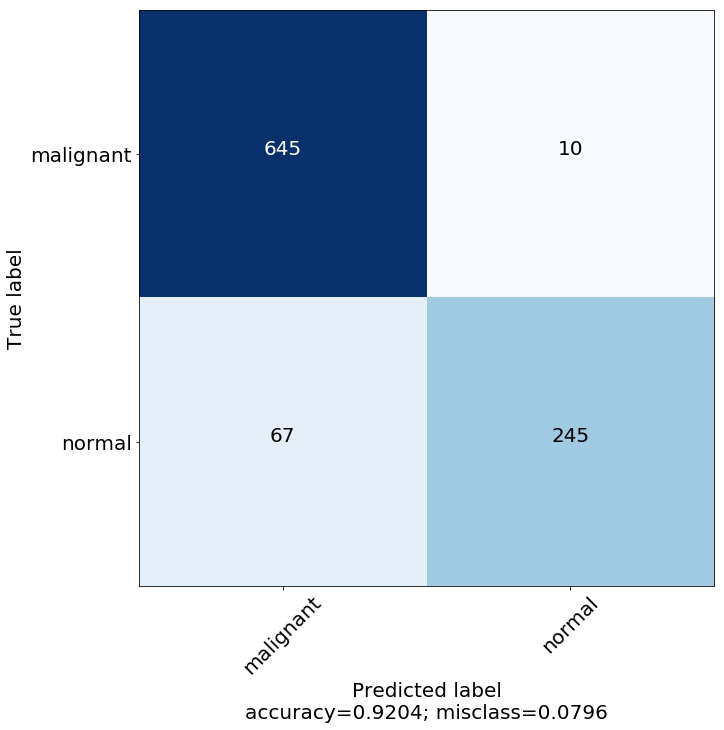

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[645  10]
 [ 67 245]]
              precision    recall  f1-score   support

      normal       0.91      0.98      0.94       655
   malignant       0.96      0.79      0.86       312

   micro avg       0.92      0.92      0.92       967
   macro avg       0.93      0.88      0.90       967
weighted avg       0.92      0.92      0.92       967



In [21]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  90.58988764044943
Specificity :  96.07843137254902


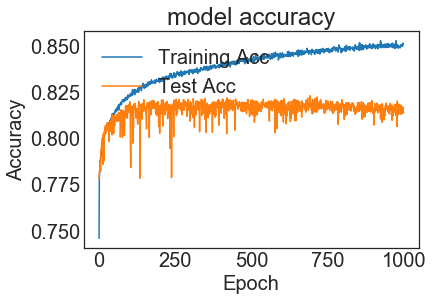

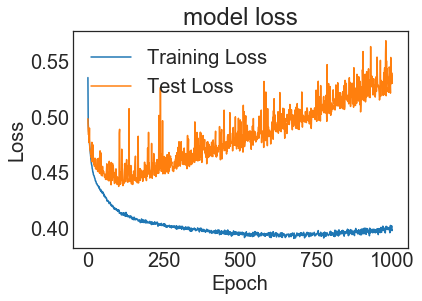

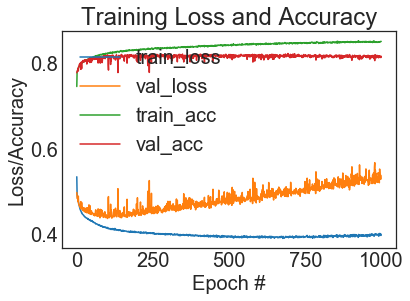

In [22]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [23]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 35us/step
Precision =  0.9236075180220236
Recall =  0.9203722854188211
f1_score =  0.9180299584183721


In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.8849946173419455


In [25]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 77/967
